In [1]:
import datetime
import backtrader as bt
import pandas as pd
import calendar
from datetime import datetime
import empyrical as ep
import pyfolio as pf
import warnings
warnings.filterwarnings('ignore')


/opt/homebrew/Caskroom/miniforge/base/envs/stock/lib/python3.13/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
def option_expiration(date):
    day = 21 - (calendar.weekday(date.year, date.month, 1) + 4) % 7
    return datetime(date.year, date.month, day)

In [3]:
class High_Low_Strategy(bt.Strategy):
    params = (
        ('period', 15),             # 回朔週期長度
        ('stop_loss_pct', 0.02),    # 2% 止損
        ('exit_pct', 0.02),         # 3% 出場
    )

    def log(self, txt, dt=None):
        '''日誌記錄函數'''
        dt = dt or self.datas[0].datetime.datetime(0)
        print(f"{dt.isoformat()}, {txt}")

    def __init__(self):
        self.datahigh = self.datas[0].high
        self.datalow = self.datas[0].low
        self.dataclose = self.datas[0].close

        # 計算過去 18 根的最高價和最低價 (不包括當前K線)
        self.highest_prev = bt.ind.Highest(self.datahigh(-1), period=self.params.period)
        self.lowest_prev = bt.ind.Lowest(self.datalow(-1), period=self.params.period)

        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return 
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f"""BUY EXECUTED, Price: {order.executed.price: .2f},
                         Cost: {order.executed.value: .2f},
                         Comm: {order.executed.comm: .2f}""")
                self.buycomm = order.executed.comm
            else:
                self.sellprice = order.executed.price
                self.log(f"""SELL EXECUTED, Price: {order.executed.price: .2f},
                         Cost: {order.executed.value: .2f},
                         Comm: {order.executed.comm: .2f}""")
            self.bar_executed = len(self)
        self.order = None
    
    def notify_trade(self, trade):
        if not trade.isclosed:
            return 
        self.log(f"OPERATION PROFIT, GROSS {trade.pnl: .2f}, NET {trade.pnlcomm: .2f}")

    def next(self):
        if self.order:
            return # 正在等待執行訂單
        
        status = None
        position_size = self.getposition().size

        if (
            option_expiration(self.datas[0].datetime.datetime(0)).day
            == self.datas[0].datetime.datetime(0).day
        ):
            if self.datas[0].datetime.datetime(0).hour >= 13:
                status = "end"
                if position_size != 0:
                    self.close()
                    self.log("Expired and Create Close Order")
        
        # 進場條件
        if status != "end":
            if not position_size:
                if self.datahigh[0] > self.highest_prev[0]:
                    self.order = self.buy()
                    self.log('創建買單')
                elif self.datalow[0] < self.lowest_prev[0]:
                    self.order = self.sell()
                    self.log('創建賣單')
            else:
                # 取得目前持倉的成本價
                entry_price = self.position.price
                # 計算出場價和止損價
                if position_size > 0:
                    # 多頭持倉
                    exit_price = self.lowest_prev[0] + (self.dataclose[0] * self.params.exit_pct)
                    stop_loss_price = entry_price - (self.dataclose[0] * self.params.stop_loss_pct)

                    # 出場條間
                    if self.datahigh[0] >= exit_price:
                        self.order = self.close()
                        self.log("平多單 - 出場條件達成")
                    # 止損條件
                    elif self.dataclose[0] <= stop_loss_price:
                        self.order = self.close()
                        self.log("平多單 - 止損")
                elif position_size < 0:
                    # 空頭持倉
                    exit_price = self.highest_prev[0] - (self.dataclose[0] * self.params.exit_pct)
                    stop_loss_price = entry_price + (self.dataclose[0] * self.params.stop_loss_pct)

                    # 出場條件
                    if self.datalow[0] <= exit_price:
                        self.order = self.close()
                        self.log("平空單 - 出場條件達成")
                    # 止損條件
                    elif self.dataclose[0] >= stop_loss_price:
                        self.order = self.close()
                        self.log("平空單 - 止損")
                        

        

Starting Portfolio Value: 300000.00
2019-03-07T09:15:00, 創建買單
2019-03-07T09:45:00, BUY EXECUTED, Price:  10330.00,
                         Cost:  167000.00,
                         Comm:  200.00
2019-03-12T11:15:00, 平多單 - 出場條件達成
2019-03-12T11:45:00, SELL EXECUTED, Price:  10380.00,
                         Cost:  167000.00,
                         Comm:  200.00
2019-03-12T11:45:00, OPERATION PROFIT, GROSS  10000.00, NET  9600.00
2019-03-14T09:15:00, 創建買單
2019-03-14T09:45:00, BUY EXECUTED, Price:  10364.00,
                         Cost:  167000.00,
                         Comm:  200.00
2019-03-20T13:15:00, Expired and Create Close Order
2019-03-20T13:45:00, SELL EXECUTED, Price:  10543.00,
                         Cost:  167000.00,
                         Comm:  200.00
2019-03-20T13:45:00, OPERATION PROFIT, GROSS  35800.00, NET  35400.00
2019-03-21T09:15:00, 創建買單
2019-03-21T09:45:00, BUY EXECUTED, Price:  10550.00,
                         Cost:  167000.00,
                       

Start date,2019-03-04
End date,2020-02-27
Total months,11
,Backtest
Annual return,137.766%
Cumulative returns,129.733%
Annual volatility,52.715%
Sharpe ratio,1.90
Calmar ratio,7.22
Stability,0.86
Max drawdown,-19.088%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,19.09,2019-05-03,2019-05-10,2019-05-31,21
1,16.77,2020-01-30,2020-02-25,NaT,NaN
2,14.84,2019-06-26,2019-08-02,2019-08-20,40
3,12.19,2019-11-06,2019-12-13,2020-01-10,48
4,9.79,2019-03-22,2019-03-25,2019-04-01,7


cum returns: 1.2973333333333303
max draw down: -0.190880643719267
sharpe: 1.9023981025221972


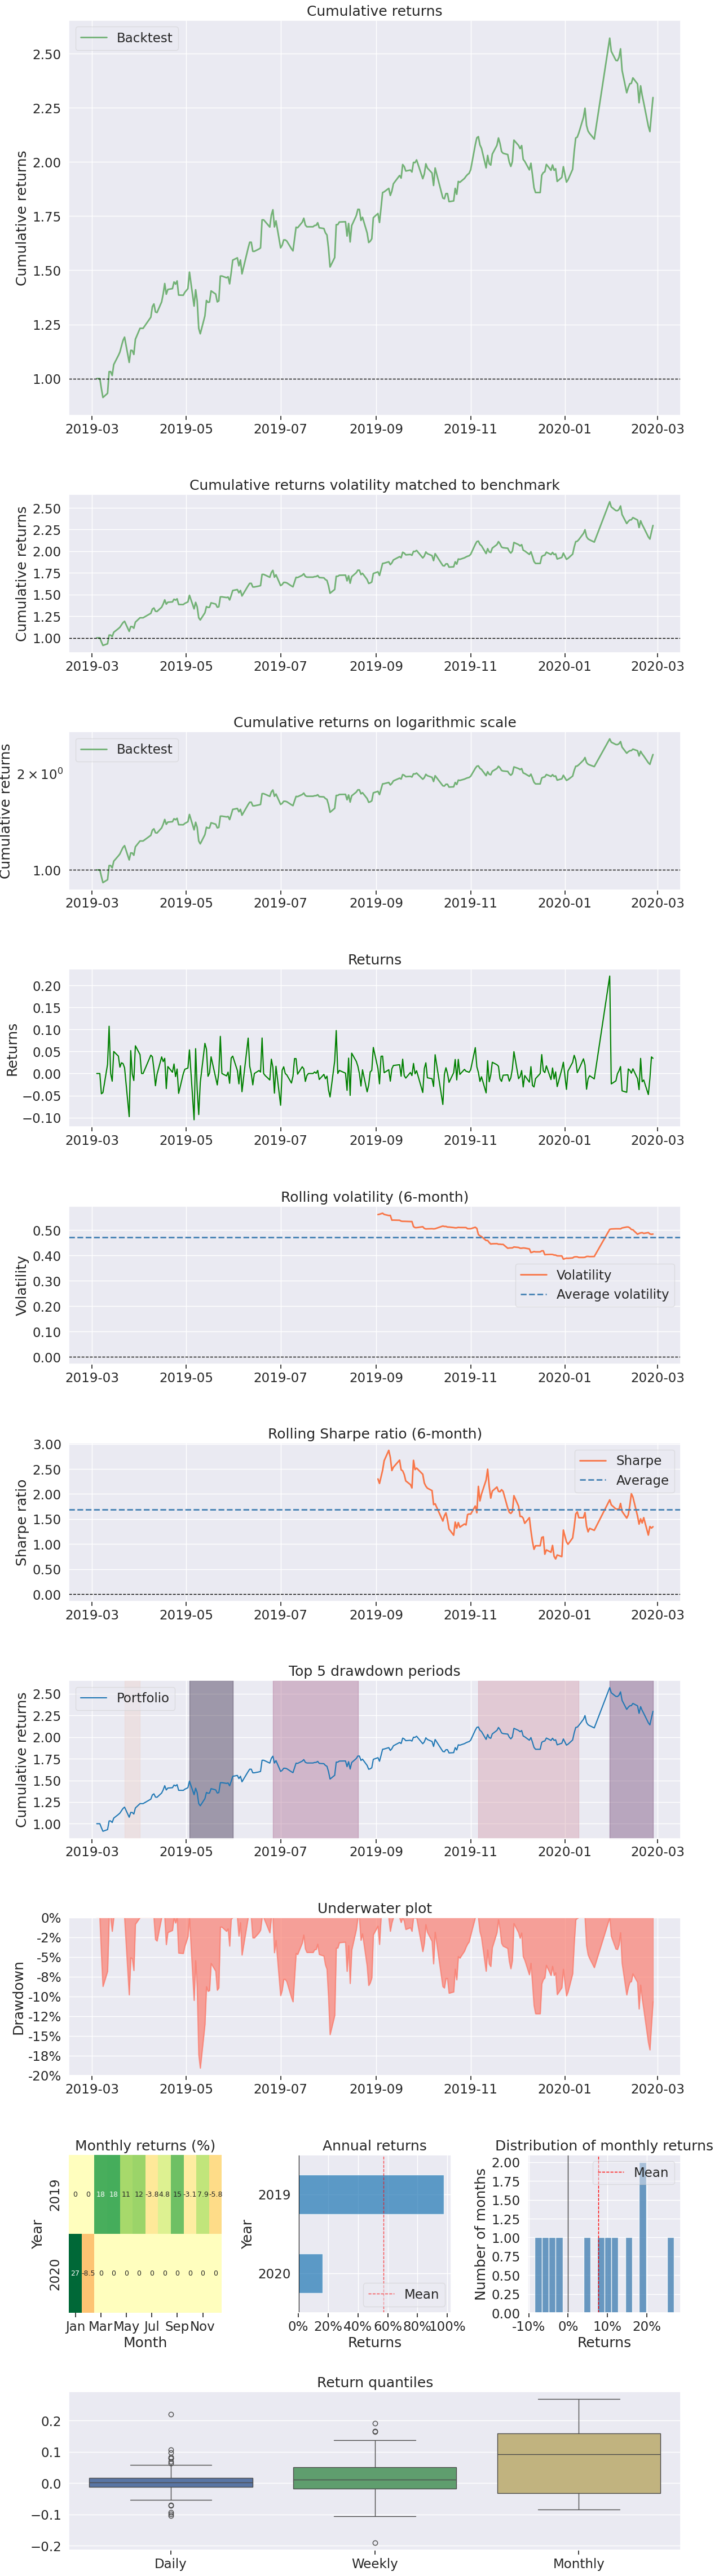

In [4]:
cerebro = bt.Cerebro()
df = pd.read_csv('TXF_30.csv')
df = df.dropna()
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
df = df.between_time('08:45', '13:45')
data_feed = bt.feeds.PandasData(
    dataname=df,
    name='TXF',
    datetime=0,
    high=2,
    low=3,
    open=1,
    close=4,
    volume=5,
    plot=False
)

cerebro.adddata(data_feed, name='TXF')

cerebro.addstrategy(High_Low_Strategy)

cerebro.broker.setcash(300000.0)
cerebro.broker.setcommission(commission=200, margin=167000, mult=200)

print("Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

results = cerebro.run()

print("Final Portfolio Value: %.2f" % cerebro.broker.getvalue())

strat = results[0]
pyfoliozer = strat.analyzers.getbyname("pyfolio")
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

pf.create_returns_tear_sheet(returns, positions=positions)
print(f"cum returns: {ep.cum_returns_final(returns)}")
print(f"max draw down: {ep.max_drawdown(returns)}")
print(f"sharpe: {ep.sharpe_ratio(returns)}")


Starting Portfolio Value: 300000.00
2019-03-07T09:15:00, 創建買單
2019-03-07T09:45:00, BUY EXECUTED, Price: 10330.00, 
                         Cost: 167000.00, 
                         Comm 200.00
2019-03-12T11:15:00, 平多單 - 出場條件達成
2019-03-12T11:45:00, SELL EXECUTED, Price: 10380.00,
                          Cost: 167000.00, 
                          Comm 200.00
2019-03-12T11:45:00, OPERATION PROFIT, GROSS 10000.00, NET 9600.00
2019-03-14T09:15:00, 創建買單
2019-03-14T09:45:00, BUY EXECUTED, Price: 10364.00, 
                         Cost: 167000.00, 
                         Comm 200.00
2019-03-20T13:15:00, Expired and Create Close Order
2019-03-20T13:45:00, SELL EXECUTED, Price: 10543.00,
                          Cost: 167000.00, 
                          Comm 200.00
2019-03-20T13:45:00, OPERATION PROFIT, GROSS 35800.00, NET 35400.00
2019-03-21T09:15:00, 創建買單
2019-03-21T09:45:00, BUY EXECUTED, Price: 10550.00, 
                         Cost: 167000.00, 
                         Comm 200

Start date,2019-03-04
End date,2020-02-27
Total months,11
,Backtest
Annual return,137.766%
Cumulative returns,129.733%
Annual volatility,52.715%
Sharpe ratio,1.90
Calmar ratio,7.22
Stability,0.86
Max drawdown,-19.088%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,19.09,2019-05-03,2019-05-10,2019-05-31,21
1,16.77,2020-01-30,2020-02-25,NaT,NaN
2,14.84,2019-06-26,2019-08-02,2019-08-20,40
3,12.19,2019-11-06,2019-12-13,2020-01-10,48
4,9.79,2019-03-22,2019-03-25,2019-04-01,7


cum returns: 1.2973333333333303
mdd: -0.190880643719267
sharpe: 1.9023981025221972


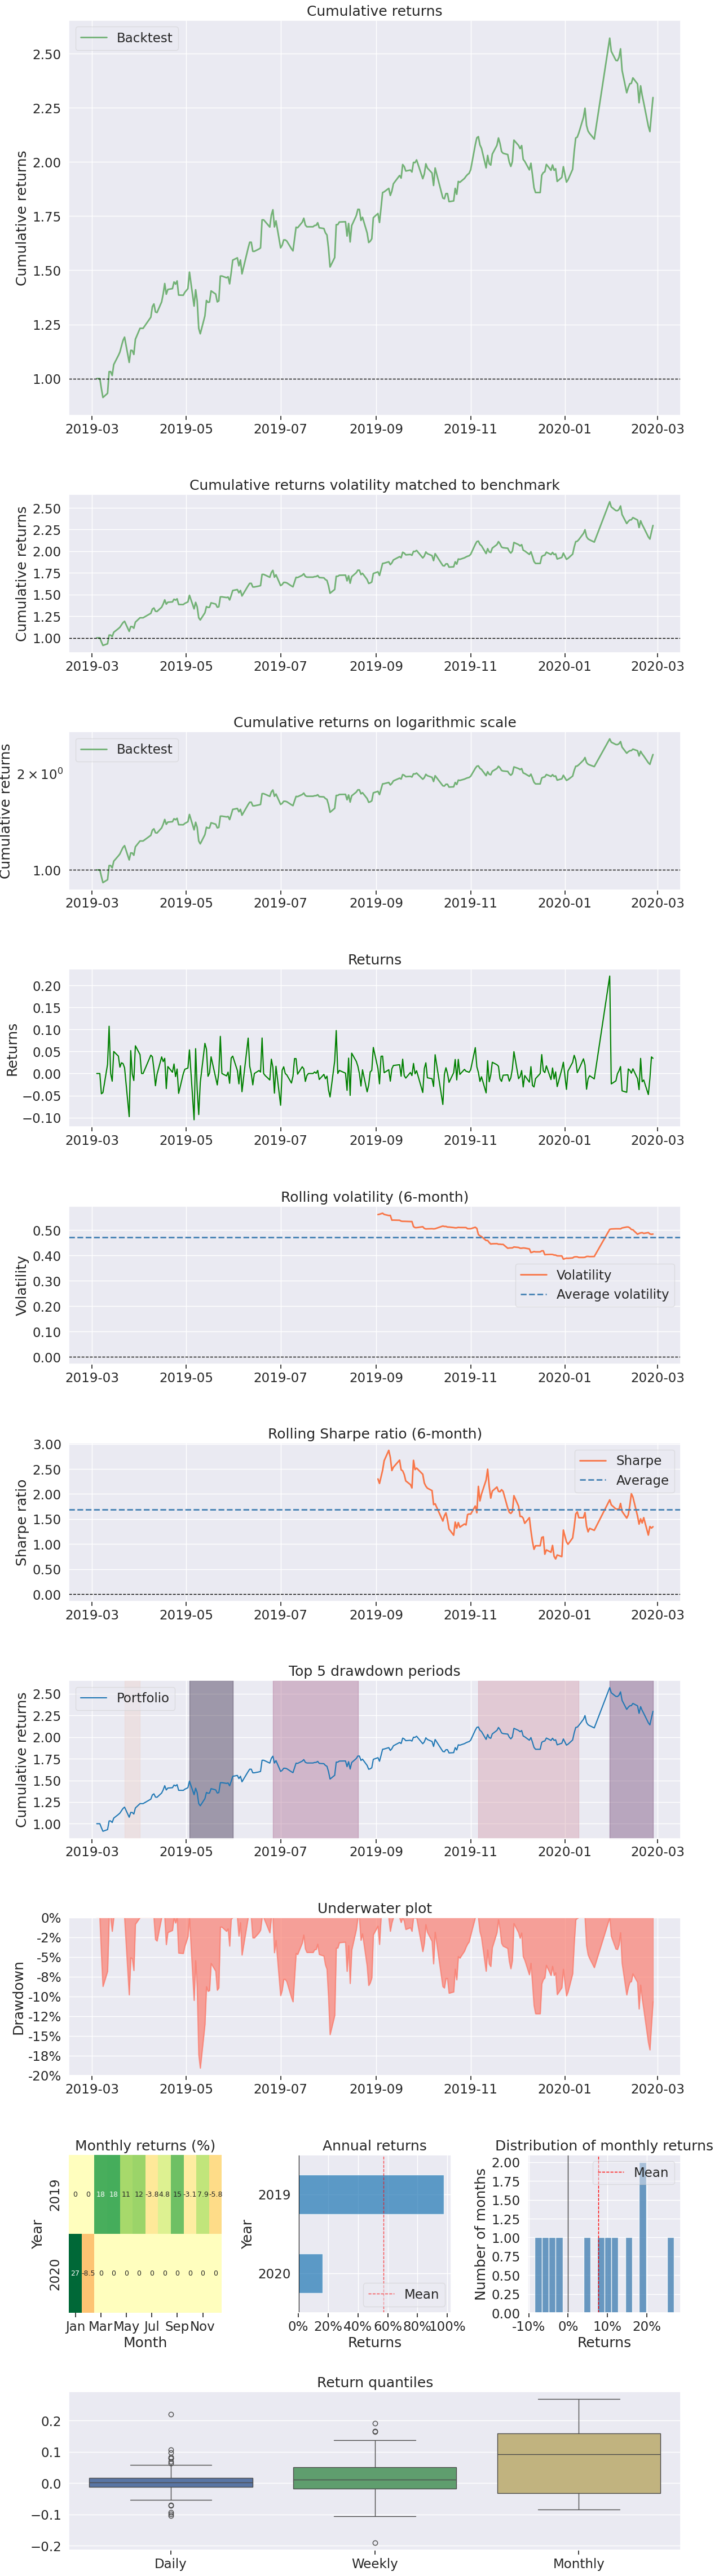

In [5]:
class High_Low_Strategy(bt.Strategy):
    params = (
        ('period', 15),            # 回溯週期長度
        ('stop_loss_pct', 0.02),   # 2% 止損
        ('exit_pct', 0.02),        # 3% 出場條件
    )

    def log(self, txt, dt=None):
        ''' 日誌記錄函數 '''
        dt = dt or self.datas[0].datetime.datetime(0)
        print(f'{dt.isoformat()}, {txt}')

    def __init__(self):
        self.datahigh = self.datas[0].high
        self.datalow = self.datas[0].low
        self.dataclose = self.datas[0].close

        # 計算過去 18 根的最高價和最低價（不包括當前K線）
        self.highest_prev = bt.ind.Highest(self.datahigh(-1), period=self.params.period)
        self.lowest_prev = bt.ind.Lowest(self.datalow(-1), period=self.params.period)

        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'''BUY EXECUTED, Price: {order.executed.price:.2f}, 
                         Cost: {order.executed.value:.2f}, 
                         Comm {order.executed.comm:.2f}''')
                self.buycomm = order.executed.comm
            else:
                self.sellprice = order.executed.price
                self.log(f'''SELL EXECUTED, Price: {order.executed.price:.2f},
                          Cost: {order.executed.value:.2f}, 
                          Comm {order.executed.comm:.2f}''')
            self.bar_executed = len(self)
        self.order = None
    
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION PROFIT, GROSS {trade.pnl:.2f}, NET {trade.pnlcomm:.2f}')

    def next(self):
        if self.order:
            return  # 正在等待訂單執行
        
        status = None
        position_size = self.getposition().size

        if (
            option_expiration(self.datas[0].datetime.datetime(0)).day
            == self.datas[0].datetime.datetime(0).day
        ):
            if self.datas[0].datetime.datetime(0).hour >= 13:
                status = "end"
                if  position_size != 0:
                    self.close()
                    self.log("Expired and Create Close Order")
        # 進場條件
        if status != 'end':
            if not position_size:
                if self.datahigh[0] > self.highest_prev[0]:
                    self.order = self.buy()
                    self.log('創建買單')
                elif self.datalow[0] < self.lowest_prev[0]:
                    self.order = self.sell()
                    self.log('創建賣單')
            else:
                # 獲取當前持倉的成本價
                entry_price = self.position.price
                # 計算出場價和止損價
                if position_size > 0:
                    # 多頭持倉
                    exit_price = self.lowest_prev[0] + (self.dataclose[0] * self.params.exit_pct)
                    stop_loss_price = entry_price - (self.dataclose[0] * self.params.stop_loss_pct)

                    # 出場條件
                    if self.datahigh[0] >= exit_price:
                        self.order = self.close()
                        self.log('平多單 - 出場條件達成')
                    # 止損條件
                    elif self.dataclose[0] <= stop_loss_price:
                        self.order = self.close()
                        self.log('平多單 - 止損')

                elif position_size < 0:
                    # 空頭持倉
                    exit_price = self.highest_prev[0] - (self.dataclose[0] * self.params.exit_pct)
                    stop_loss_price = entry_price + (self.dataclose[0] * self.params.stop_loss_pct)

                    # 出場條件
                    if self.datalow[0] <= exit_price:
                        self.order = self.close()
                        self.log('平空單 - 出場條件達成')
                    # 止損條件
                    elif self.dataclose[0] >= stop_loss_price:
                        self.order = self.close()
                        self.log('平空單 - 止損')





cerebro = bt.Cerebro()
df = pd.read_csv('TXF_30.csv')
df = df.dropna()
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
df = df.between_time('08:45', '13:45')
data_feed = bt.feeds.PandasData(
    dataname=df,
    name='TXF',
    datetime=0,
    high=2,
    low=3,
    open=1,
    close=4,
    volume=5,
    plot=False,
)
cerebro.adddata(data_feed, name='TXF')

cerebro.addstrategy(High_Low_Strategy)

cerebro.broker.setcash(300000.0)
cerebro.broker.setcommission(commission=200, margin=167000, mult=200)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

results = cerebro.run()

print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

pf.create_returns_tear_sheet(returns, positions=positions)
print('cum returns:', ep.cum_returns_final(returns))
print('mdd:', ep.max_drawdown(returns))
print('sharpe:', ep.sharpe_ratio(returns))